In [1]:
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer, ColorMode
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper
import matplotlib.pyplot as plt
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import numpy as np
import os
import json
import random
import cv2
import shutil
from detectron2.data import build_detection_test_loader, build_detection_train_loader
import copy
from detectron2.data import detection_utils as utils
import torch

# Constants

In [2]:
setup_logger()
dataset_dir = "dataset/"
train_dir = dataset_dir + "train"
val_dir = dataset_dir + "val"
test_dir = dataset_dir + "test"
#classes = ["red", "pink", "yellow", "blue", "orange", "green"]
classes = ["red", "pink", "yellow", "orange", "green"]
camera_rows = 516
camera_cols = 656

# Registering Datasets

In [3]:
def get_data(img_dir):
    dataset_dicts = []
    for index, filename in enumerate([file for file in os.listdir(img_dir) if file.endswith('.json')]):
        json_file = os.path.join(img_dir, filename)
        with open(json_file) as f:
            img_label = json.load(f)

        record = {}
        
        img = os.path.join(img_dir, img_label["imagePath"])
        
        record["file_name"] = img
        record["height"] = camera_rows
        record["width"] = camera_cols
        record["image_id"] = index
        shapes = img_label["shapes"]
        objs = []
        for shape in shapes:
            px = [a[0] for a in shape['points']]
            py = [a[1] for a in shape['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(shape['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [4]:
for d in ["train", "val", "test"]:
    DatasetCatalog.register(d, lambda d=d: get_data(dataset_dir + d))
    MetadataCatalog.get(d).set(thing_classes=classes)

# Visualize Labels

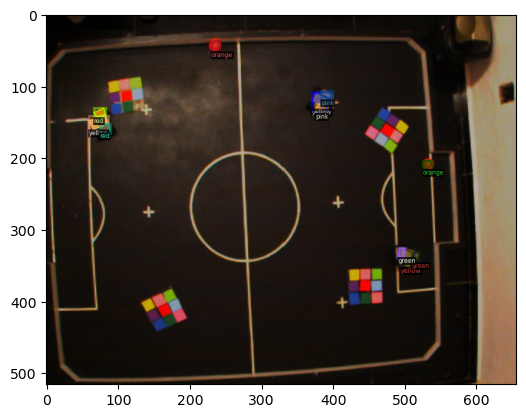

In [5]:
dataset_dicts = get_data(train_dir)
train_metadata = MetadataCatalog.get("train")
test_metadata = MetadataCatalog.get("test")
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[..., ::-1][..., ::-1])

# Set Configs

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE = "cuda"
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("test", )
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 3
cfg.INPUT.RANDOM_FLIP = "horizontal"
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 300
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.SOLVER.STEPS = []   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes) 


# Augmentate Data

In [7]:
def mapper(dataset_dict):
    # Implement a mapper, similar to the default DatasetMapper, but with your own customizations
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="RGB")
    transform_list = [T.Resize((800,800)),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False), 
                    T.RandomContrast(0.8, 1.3),
                    T.RandomSaturation(0.8, 1.3),
                    T.RandomRotation(angle=[90, 90]),
                          T.RandomBrightness(0.8, 1.3),
                            T.RandomCrop("absolute", (640, 640))
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

# Train Model

In [8]:
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=mapper)


In [9]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)

[12/12 23:47:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (5, 256, 1, 1) 

In [10]:
trainer.train()

[12/12 23:47:14 d2.engine.train_loop]: Starting training from iteration 0


/home/samcbk/anaconda3/envs/ct213/lib/python3.9/site-packages/fvcore/transforms/transform.py:434: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  tensor = torch.from_numpy(np.ascontiguousarray(img))
/home/samcbk/anaconda3/envs/ct213/lib/python3.9/site-packages/fvcore/transforms/transform.py:434: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of t

[12/12 23:47:22 d2.utils.events]:  eta: 0:01:37  iter: 19  total_loss: 3.074  loss_cls: 1.445  loss_box_reg: 0.4083  loss_mask: 0.6873  loss_rpn_cls: 0.3035  loss_rpn_loc: 0.2378  time: 0.3438  data_time: 0.0137  lr: 0.00016068  max_mem: 2388M
[12/12 23:47:29 d2.utils.events]:  eta: 0:01:35  iter: 39  total_loss: 2.234  loss_cls: 0.6992  loss_box_reg: 0.6387  loss_mask: 0.6345  loss_rpn_cls: 0.08367  loss_rpn_loc: 0.1677  time: 0.3642  data_time: 0.0046  lr: 0.00032718  max_mem: 2570M
[12/12 23:47:37 d2.utils.events]:  eta: 0:01:31  iter: 59  total_loss: 2.068  loss_cls: 0.5811  loss_box_reg: 0.727  loss_mask: 0.5571  loss_rpn_cls: 0.04144  loss_rpn_loc: 0.1473  time: 0.3773  data_time: 0.0046  lr: 0.00049367  max_mem: 2671M
[12/12 23:47:45 d2.utils.events]:  eta: 0:01:25  iter: 79  total_loss: 1.803  loss_cls: 0.4716  loss_box_reg: 0.6956  loss_mask: 0.4605  loss_rpn_cls: 0.03182  loss_rpn_loc: 0.133  time: 0.3834  data_time: 0.0043  lr: 0.00066017  max_mem: 2671M
[12/12 23:47:54 d2.u

# Visualize Augmentation

In [11]:
train_data_loader = trainer.build_train_loader(cfg)
data_iter = iter(train_data_loader)
batch = next(data_iter)

[12/12 23:50:42 d2.data.build]: Removed 0 images with no usable annotations. 40 images left.
[12/12 23:50:42 d2.data.build]: Using training sampler TrainingSampler
[12/12 23:50:42 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[12/12 23:50:42 d2.data.common]: Serializing 40 elements to byte tensors and concatenating them all ...
[12/12 23:50:42 d2.data.common]: Serialized dataset takes 0.09 MiB


/home/samcbk/anaconda3/envs/ct213/lib/python3.9/site-packages/fvcore/transforms/transform.py:434: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  tensor = torch.from_numpy(np.ascontiguousarray(img))


/home/samcbk/anaconda3/envs/ct213/lib/python3.9/site-packages/fvcore/transforms/transform.py:434: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  tensor = torch.from_numpy(np.ascontiguousarray(img))


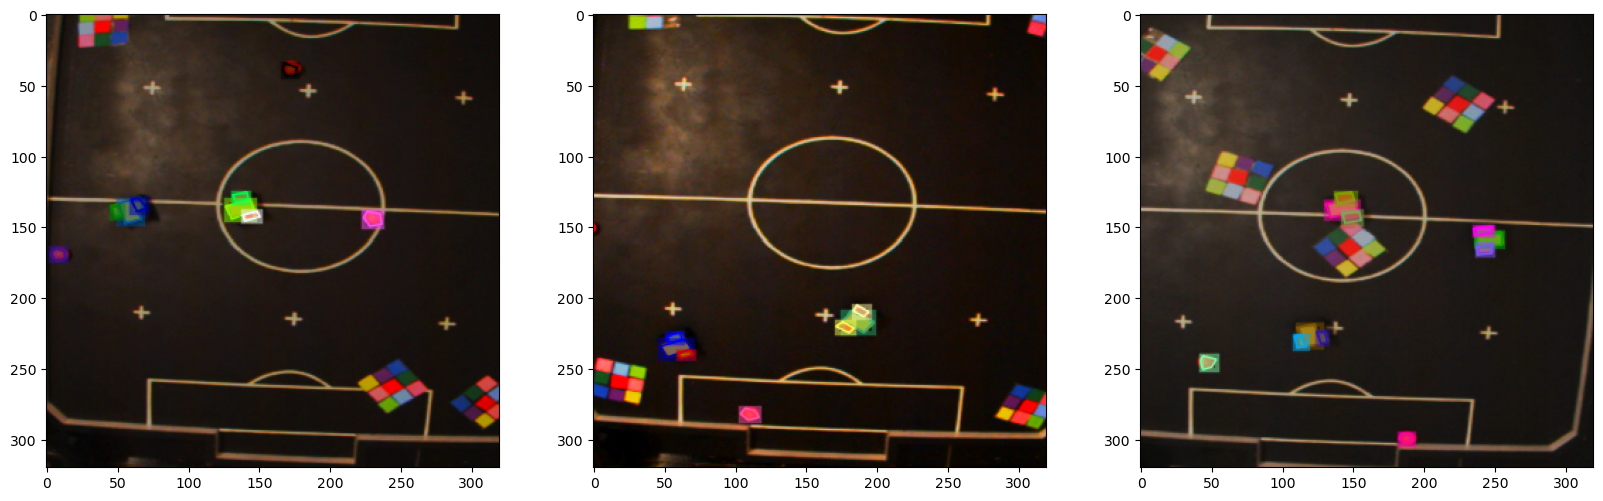

In [12]:
rows, cols = 3, 3
plt.figure(figsize=(20,20))

for i, per_image in enumerate(batch[:int(rows*cols)]):
    plt.subplot(rows, cols, i+1)
    img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
    img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

    visualizer = Visualizer(img, metadata=train_metadata, scale=0.5)

    target_fields = per_image["instances"].get_fields()
    labels = None
    vis = visualizer.overlay_instances(
        labels=labels,
        boxes=target_fields.get("gt_boxes", None),
        masks=target_fields.get("gt_masks", None),
        keypoints=target_fields.get("gt_keypoints", None),
    )
    plt.imshow(vis.get_image()[:, :, ::-1])

# Test Model

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7

predictor = DefaultPredictor(cfg)

[12/12 23:50:52 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [14]:
for index, filename in enumerate([file for file in os.listdir(test_dir) if not (file.endswith('.json') or file.startswith('output'))]):
    im = cv2.imread(test_dir +"/"+ filename)
    outputs = predictor(im) 
    v = Visualizer(im[:, :, ::-1], metadata=test_metadata) 
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite(test_dir + "/output_" + filename, out.get_image()[..., ::-1])

In [15]:
for index, filename in enumerate(os.listdir(val_dir)):
    if filename.endswith('.json') or filename.startswith('output'):
        continue
    im = cv2.imread(val_dir + "/" + filename)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=test_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite(val_dir + "/output_" + filename, out.get_image()[..., ::-1])

# Evaluate Model

In [16]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("test", cfg, False, "./output/")
val_loader = build_detection_test_loader(cfg, "test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [12/12 23:50:57 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/12 23:50:57 d2.evaluation.coco_evaluation]: Trying to convert 'test' to COCO format ...
WARNING [12/12 23:50:57 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[12/12 23:50:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/12 23:50:57 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common.NumpySerializedList'>
[12/12 23:50:57 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[12/12 23:50:57 d2.data.common]: Serialized dataset takes 0.02 MiB
[12/12 23:50:57 d2.evaluation.evaluator]: Start inference on 10 batche

AssertionError: 

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)